# Business Case 4: Cryptocurrencies Forecasting

## Contents:
  
 * [Modeling BTC](#Modeling)
 * [BTC - Entire Dataset](#entiredataset)
    * [Model 1: LSTM](#lstm)
    * [Model 2: XGBOOST Regressor](#xgboost)
 * [BTC - since January 2021](#jan2021)
    * [Model 1: LSTM](#lstm2)
    * [Model 2: XGBOOST Regressor](#xgboost2)
 * [BTC - since January 2022](#jan2022)
    * [Model 1: LSTM](#lstm3)
    * [Model 2: XGBOOST Regressor](#xgboost3)
 * [Predictions for the next two days using the best model](#predictions)
 * [Final Predictions](#finalpredictions)

## Imports

In [1]:
#! pip install xgboost
#! pip install --upgrade tensorflow
#! pip install keras
#! pip install pystan

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import ceil
import math
import scipy.stats as stats
from itertools import cycle

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

import json
import requests
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error , mean_absolute_error, explained_variance_score, r2_score
from tensorflow.keras import layers
from xgboost import XGBRegressor

import warnings

# Modeling - BTC <a name="Modeling"></a>
>In this step, we decided to implement algorithms (LSTM, XGBOOST Regressor) that can predict the closing price of BTC.

# BTC - Entire Dataset <a name="entiredataset"></a>

In [3]:
btc = pd.read_csv('BTC.csv', index_col = 'Date')
btc.head()

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2017-05-11,0.001888,0.001034,0.916674,0.007758,0.161794,0.997115,0.115186
2017-05-12,0.000000,0.000867,0.871722,0.011149,0.217227,0.984991,0.112062
2017-05-13,0.001225,0.000406,0.858071,0.011131,0.233195,0.999081,0.112062
2017-05-14,0.001286,0.000000,0.830401,0.002793,0.067387,0.997439,0.112062
2017-05-15,0.000216,0.000840,0.820756,0.006643,0.138430,0.991538,0.145706


# Model 1: LSTM <a name="lstm"></a>

In [4]:
data = btc.copy()
data.head()

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2017-05-11,0.001888,0.001034,0.916674,0.007758,0.161794,0.997115,0.115186
2017-05-12,0.000000,0.000867,0.871722,0.011149,0.217227,0.984991,0.112062
2017-05-13,0.001225,0.000406,0.858071,0.011131,0.233195,0.999081,0.112062
2017-05-14,0.001286,0.000000,0.830401,0.002793,0.067387,0.997439,0.112062
2017-05-15,0.000216,0.000840,0.820756,0.006643,0.138430,0.991538,0.145706


In [5]:
#Splitting the original dataset using all the variables (hist) and "close" (target) using 7 days as the length of the sliding window

hist = []
target = []
length = 7

for i in range(len(data)-length):
    t = data['close']
    v = data[['close', 'volume', 'spread', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [6]:
print(len(hist[0]))  #nr of days
print(len(hist)) #size of train dataset
print(len(target)) #size of test dataset

7
1804
1804


In [7]:
#convert lists to arrays
hist = np.array(hist)
target = np.array(target)

In [8]:
target = target.reshape(-1,1)
target.shape

(1804, 1)

In [9]:
#Splitting the datasets into train and test using 80% for train and 20% for test

training_size=int(len(data)*0.80)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [10]:
#Nr of instances, # nr of days (length), #nr of columns
X_train.shape

(1448, 7, 6)

In [11]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=40, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 20)             2160      
                                                                 
 lstm_1 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_2 (LSTM)               (None, 40)                11680     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 20,665
Trainable params: 20,665
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [13]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, shuffle = False, validation_split=0.2)

Epoch 1/30
37/37 [==============================] - 5s 41ms/step - loss: 0.0466 - val_loss: 0.3339
Epoch 2/30
37/37 [==============================] - 0s 12ms/step - loss: 0.0427 - val_loss: 0.3273
Epoch 3/30
37/37 [==============================] - 0s 11ms/step - loss: 0.0397 - val_loss: 0.3137
Epoch 4/30
37/37 [==============================] - 0s 11ms/step - loss: 0.0392 - val_loss: 0.3080
Epoch 5/30
37/37 [==============================] - 0s 11ms/step - loss: 0.0375 - val_loss: 0.2910
Epoch 6/30
37/37 [==============================] - 0s 10ms/step - loss: 0.0368 - val_loss: 0.2807
Epoch 7/30
37/37 [==============================] - 0s 10ms/step - loss: 0.0348 - val_loss: 0.2564
Epoch 8/30
37/37 [==============================] - 0s 10ms/step - loss: 0.0329 - val_loss: 0.2194
Epoch 9/30
37/37 [==============================] - 0s 10ms/step - loss: 0.0306 - val_loss: 0.1678
Epoch 10/30
37/37 [==============================] - 0s 10ms/step - loss: 0.0286 - val_loss: 0.1069
Epoch 11/

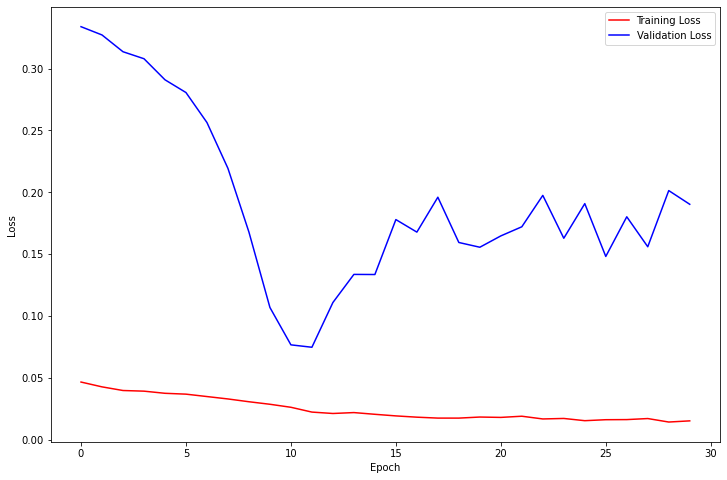

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [15]:
pred_test = model.predict(X_test)
pred_train = model.predict (X_train)

In [16]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
351,0.589332,0.258333,2022-04-21
352,0.577378,0.259876,2022-04-22
353,0.573527,0.263556,2022-04-23
354,0.573262,0.266270,2022-04-24
355,0.588283,0.266718,2022-04-25


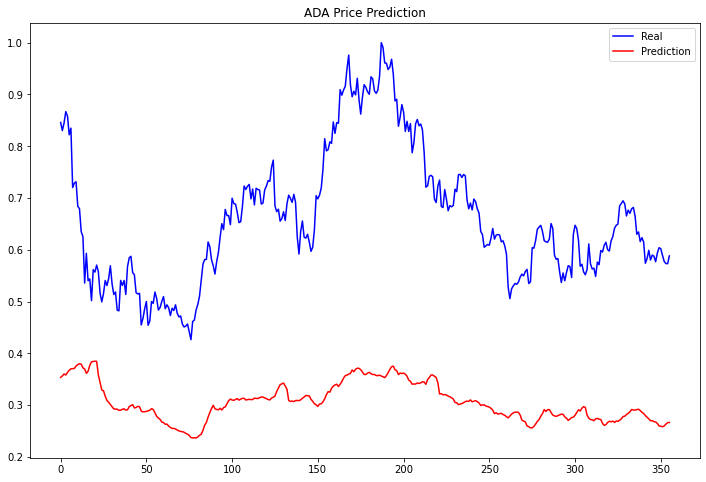

In [17]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('ADA Price Prediction')
plt.legend()
plt.show()

In [18]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.11860376870211896
Train data MSE:  0.014066853950345733
Train data MAE:  0.04703047384004513
-------------------------------------------------------------------------------------
Test data RMSE:  0.36824338726453876
Test data MSE:  0.13560319226406106
Test data MAE:  0.35268833114291553


In [19]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.5937029838909573
Test data R2 score: -7.087322520455938


# Model 2: XGBoost Regressor  <a name="xgboost"></a>

In [20]:
data1 = btc.copy()
data1.reset_index(inplace = True)
data1.shape

(1811, 8)

In [21]:
close_stock = data1.copy()
print("Total data for prediction: ",data1.shape[0])

Total data for prediction:  1811


In [22]:
data1.set_index('Date', inplace = True)
data1.shape

(1811, 7)

In [23]:
#Train and test split using 80% for train and 20% for test
training_size=int(len(data1)*0.80)
test_size=len(data1)-training_size
train_data,test_data=data1.iloc[:training_size,:],data1.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1448, 7)
test_data:  (363, 7)


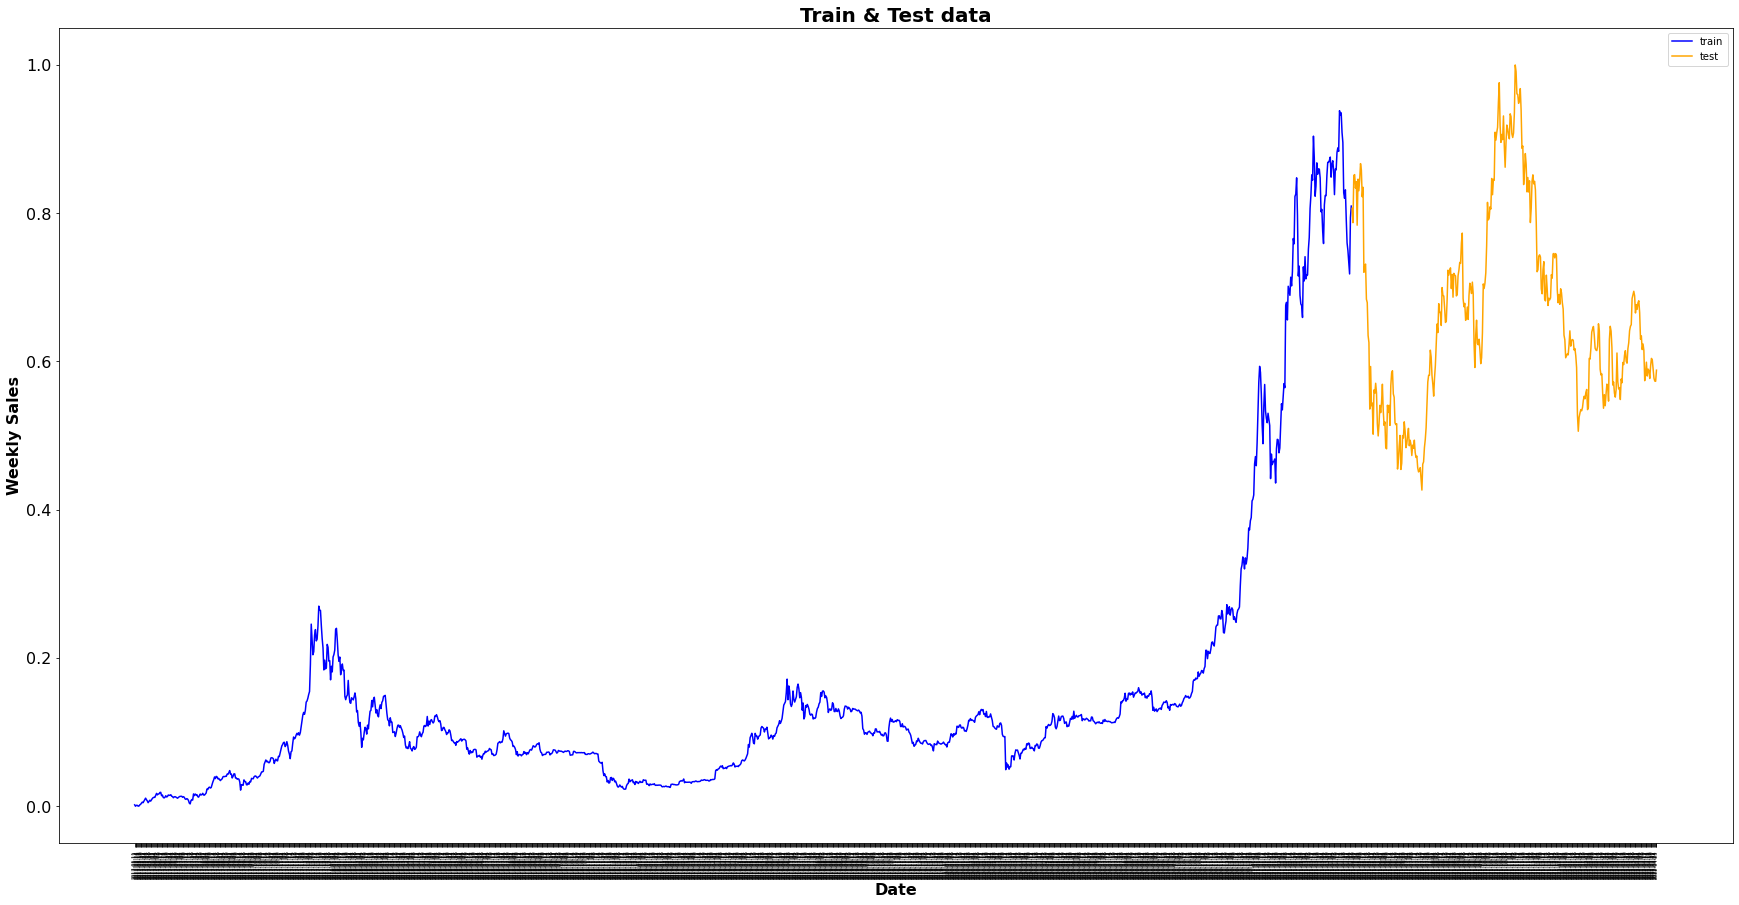

In [24]:
data1.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(30, 15))
sns.lineplot(x = close_stock['Date'][:training_size], y = close_stock['close'][:training_size], color = 'blue')
sns.lineplot(x = close_stock['Date'][training_size:], y = close_stock['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', labelsize=5)
plt.xticks(rotation='vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [25]:
data1.set_index('Date', inplace = True)

In [26]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), 0:]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [27]:
#Sliding window = 7 or 20
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1440, 7, 7)
y_train:  (1440,)
X_test:  (355, 7, 7)
y_test (355,)


In [28]:
#Reshaping the arrays because XGBRegressor only accepts 1-Dimensional arrays
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [29]:
model1 = XGBRegressor(n_estimators=100, random_state = 1, eta = 0.2)
model1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0, ...)

In [30]:
predictions = model1.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model1.predict(X_train)

In [31]:
results2 = np.concatenate((y_test, predictions),axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data1['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
350,0.602196,0.617328,2022-04-21
351,0.589332,0.599934,2022-04-22
352,0.577378,0.602536,2022-04-23
353,0.573527,0.613977,2022-04-24
354,0.573262,0.601378,2022-04-25


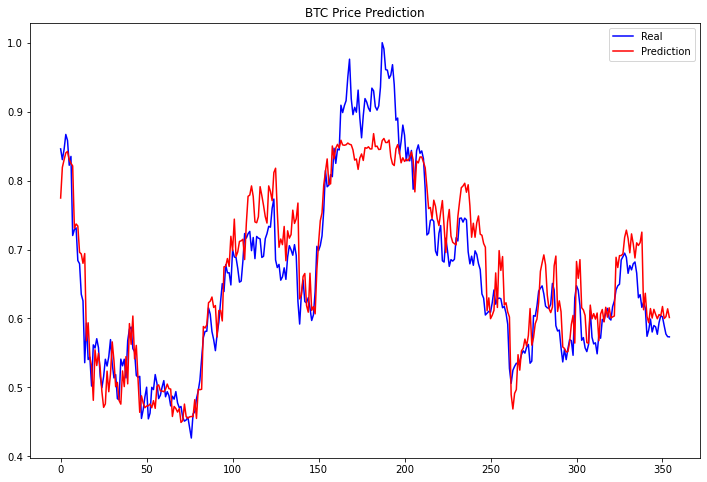

In [32]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(predictions, color='red', label='Prediction')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()

In [33]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  5.169435672406569e-07
Mean Absolute Error - MAE : 0.0005253786561106846
Root Mean squared Error - RMSE : 0.0007189878769775308
R^2 Score 0.9999839962580233
--------------------------------------------------------------
Test data MSE:  0.0021693183307005923
Mean Absolute Error - MAE : 0.03578854359767369
Root Mean squared Error - RMSE : 0.04657594154389788
R^2 Score 0.8708776401753007


# BTC - since January 2021  <a name="jan2021"></a>

# Model 1: LSTM <a name="lstm2"></a>

In [34]:
data2 = btc.copy()
data2.reset_index(inplace = True)
data2 = data2[data2['Date'] >= '2021-01-01']
data2.set_index('Date', inplace = True)
print("Total data for prediction: ",data2.shape[0])

Total data for prediction:  480


In [35]:
hist = []
target = []
length = 7

for i in range(len(data2)-length):
    t = data2['close']
    v = data2[['close','volume', 'spread', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [36]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
473
473


In [37]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [38]:
target = target.reshape(-1,1)
target.shape

(473, 1)

In [39]:
training_size = int(len(data2)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [40]:
X_train.shape

(384, 7, 6)

In [41]:
model2 = tf.keras.Sequential()

model2.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model2.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model2.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model2.add(layers.Dense(units=1))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 20)             2160      
                                                                 
 lstm_4 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,297
Trainable params: 17,297
Non-trainable params: 0
_________________________________________________________________


In [42]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [43]:
history = model2.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
10/10 [==============================] - 4s 77ms/step - loss: 0.4013 - val_loss: 0.3546
Epoch 2/30
10/10 [==============================] - 0s 13ms/step - loss: 0.1926 - val_loss: 0.1188
Epoch 3/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0381 - val_loss: 0.0121
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0548 - val_loss: 0.0526
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0304 - val_loss: 0.0430
Epoch 6/30
10/10 [==============================] - 0s 13ms/step - loss: 0.0276 - val_loss: 0.0247
Epoch 7/30
10/10 [==============================] - 0s 14ms/step - loss: 0.0299 - val_loss: 0.0262
Epoch 8/30
10/10 [==============================] - 0s 13ms/step - loss: 0.0298 - val_loss: 0.0284
Epoch 9/30
10/10 [==============================] - 0s 13ms/step - loss: 0.0268 - val_loss: 0.0207
Epoch 10/30
10/10 [==============================] - 0s 13ms/step - loss: 0.0248 - val_loss: 0.0200
Epoch 11/

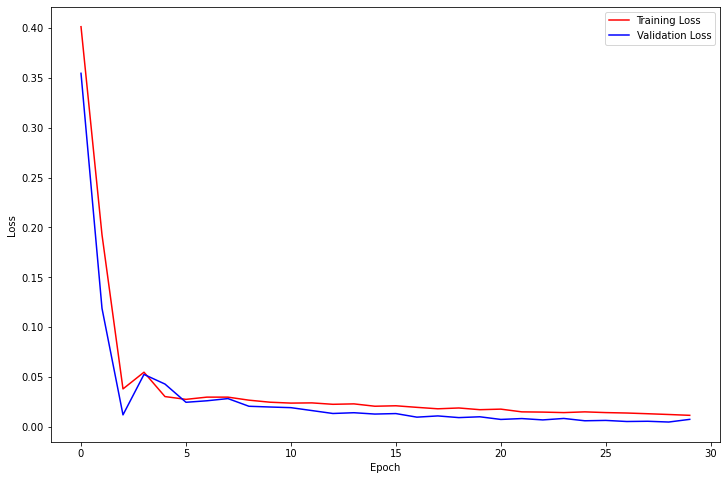

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [45]:
pred_test = model2.predict(X_test)
pred_train = model2.predict (X_train)

In [46]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data2['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()
results.head()

,y_test,Predictions,Date
0,0.537858,0.544493,2022-01-27
1,0.547671,0.541344,2022-01-28
2,0.553045,0.547715,2022-01-29
3,0.549695,0.553433,2022-01-30
4,0.558284,0.556729,2022-01-31


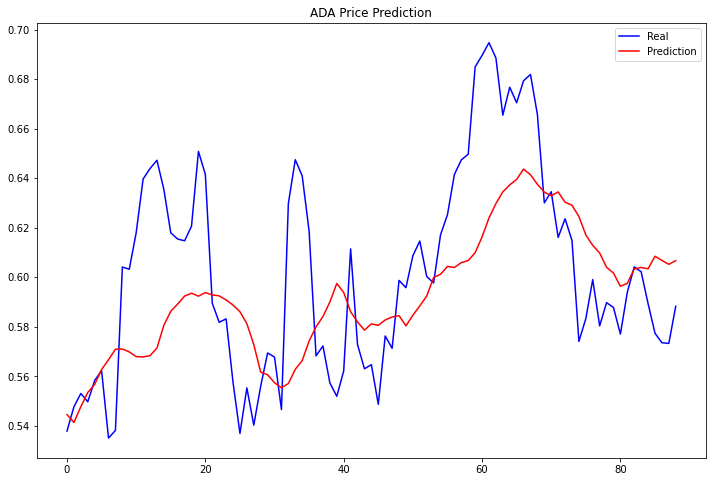

In [47]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('ADA Price Prediction')
plt.legend()
plt.show()

In [48]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.12146976294468982
Train data MSE:  0.01475490330983914
Train data MAE:  0.10005158243890144
-------------------------------------------------------------------------------------
Test data RMSE:  0.03540136607396008
Test data MSE:  0.0012532567199025314
Test data MAE:  0.028158804030819194


In [49]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.29084769482688877
Test data R2 score: 0.2736728947914283


# Model 2: XGBoost Regressor   <a name="xgboost2"></a>

In [50]:
data3 = btc.copy()

In [51]:
data3.reset_index(inplace = True)
data3 = data3[data3['Date'] >= '2021-01-01']               
data3.set_index('Date', inplace = True)
print("Total data for prediction: ",data3.shape[0])

Total data for prediction:  480


In [52]:
data3.shape

(480, 7)

In [53]:
training_size=int(len(data3)*0.80)
test_size=len(data3)-training_size
train_data,test_data=data3.iloc[:training_size,:],data3.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (384, 7)
test_data:  (96, 7)


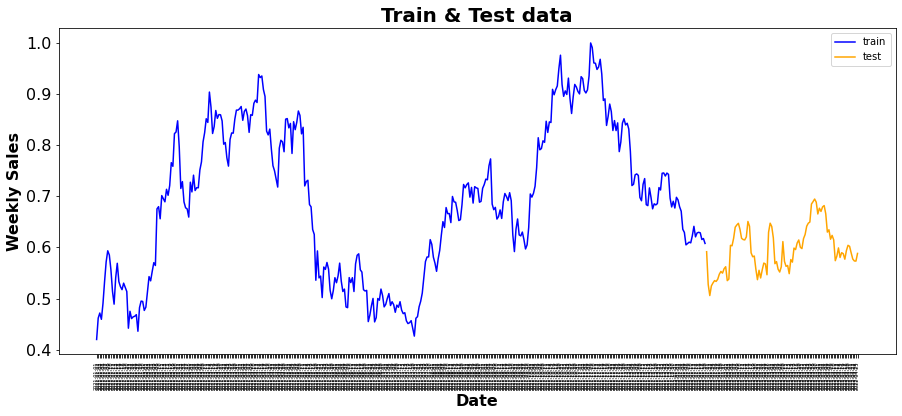

In [54]:
data3.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data3['Date'][:training_size], y = data3['close'][:training_size], color = 'blue')
sns.lineplot(x = data3['Date'][training_size:], y =data3['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [55]:
data3.set_index('Date', inplace = True)

In [56]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [57]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (376, 7, 7)
y_train:  (376,)
X_test:  (88, 7, 7)
y_test (88,)


In [58]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [59]:
model3 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model3.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [60]:
predictions = model3.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model3.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [61]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data3['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
83,0.602196,0.629623,2022-04-21
84,0.589332,0.625307,2022-04-22
85,0.577378,0.621578,2022-04-23
86,0.573527,0.606844,2022-04-24
87,0.573262,0.602756,2022-04-25


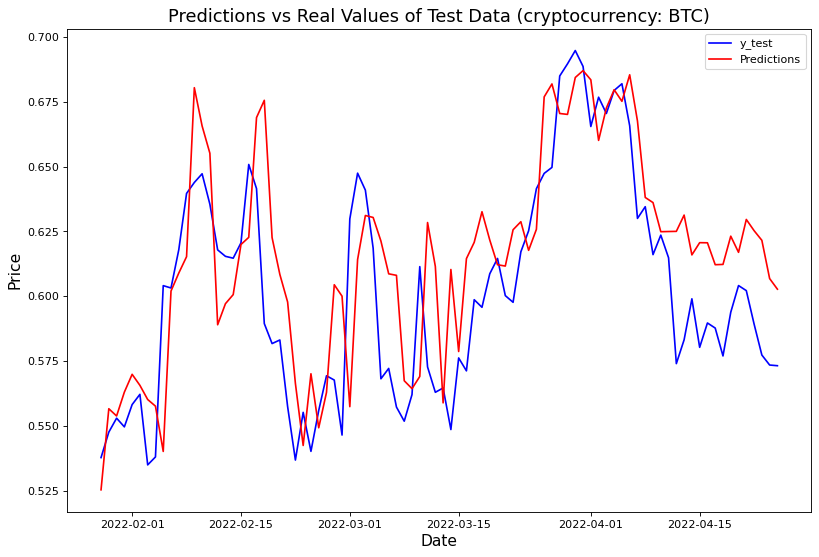

In [62]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: BTC)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [63]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  3.8195068388761725e-07
Mean Absolute Error - MAE : 0.0004562188254484805
Root Mean squared Error - RMSE : 0.0006180215885287643
R^2 Score 0.9999815947270366
--------------------------------------------------------------
Test data MSE:  0.000919532754733495
Mean Absolute Error - MAE : 0.02443548519110011
Root Mean squared Error - RMSE : 0.03032379848787904
R^2 Score 0.4724136192809203


# BTC - since January 2022  <a name="jan2022"></a>

# Model 1: LSTM <a name="lstm3"></a>

In [64]:
data4 = btc.copy()
data4.reset_index(inplace = True)
data4 = data4[data4['Date'] >= '2022-01-01']
data4.set_index('Date', inplace = True)
print("Total data for prediction: ",data4.shape[0])

Total data for prediction:  115


In [65]:
hist = []
target = []
length = 7

for i in range(len(data4)-length):
    t = data4['close']
    v = data4[['close','volume', 'spread', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [66]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
108
108


In [67]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [68]:
target = target.reshape(-1,1)
target.shape

(108, 1)

In [69]:
training_size = int(len(data4)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [70]:
X_train.shape

(92, 7, 6)

In [71]:
model4 = tf.keras.Sequential()

model4.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model4.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model4.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model4.add(layers.Dense(units=1))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 20)             2160      
                                                                 
 lstm_7 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,297
Trainable params: 17,297
Non-trainable params: 0
_________________________________________________________________


In [72]:
model4.compile(optimizer='adam', loss='mean_squared_error')

In [73]:
history = model4.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
3/3 [==============================] - 4s 286ms/step - loss: 0.3094 - val_loss: 0.3571
Epoch 2/30
3/3 [==============================] - 0s 23ms/step - loss: 0.2706 - val_loss: 0.3099
Epoch 3/30
3/3 [==============================] - 0s 23ms/step - loss: 0.2288 - val_loss: 0.2543
Epoch 4/30
3/3 [==============================] - 0s 24ms/step - loss: 0.1761 - val_loss: 0.1900
Epoch 5/30
3/3 [==============================] - 0s 23ms/step - loss: 0.1173 - val_loss: 0.1176
Epoch 6/30
3/3 [==============================] - 0s 19ms/step - loss: 0.0597 - val_loss: 0.0457
Epoch 7/30
3/3 [==============================] - 0s 18ms/step - loss: 0.0118 - val_loss: 0.0025
Epoch 8/30
3/3 [==============================] - 0s 22ms/step - loss: 0.0277 - val_loss: 0.0023
Epoch 9/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0329 - val_loss: 6.0327e-04
Epoch 10/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0178 - val_loss: 0.0064
Epoch 11/30
3/3 [=======

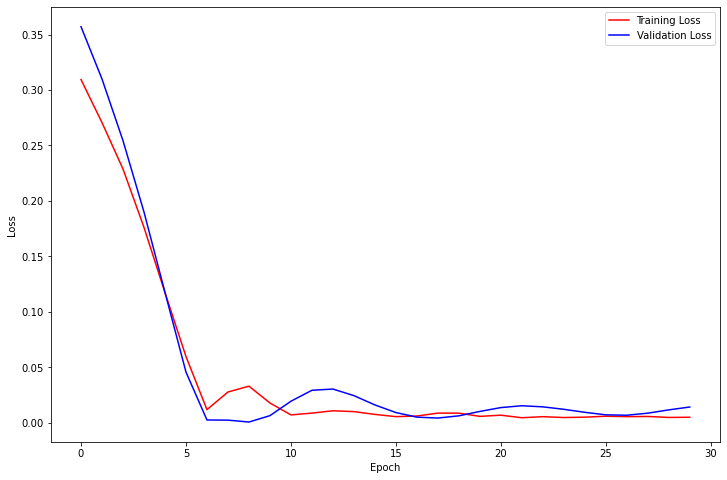

In [74]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [75]:
pred_test = model4.predict(X_test)
pred_train = model4.predict (X_train)

In [76]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data4['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
11,0.589332,0.521357,2022-04-21
12,0.577378,0.525350,2022-04-22
13,0.573527,0.522253,2022-04-23
14,0.573262,0.520072,2022-04-24
15,0.588283,0.521304,2022-04-25


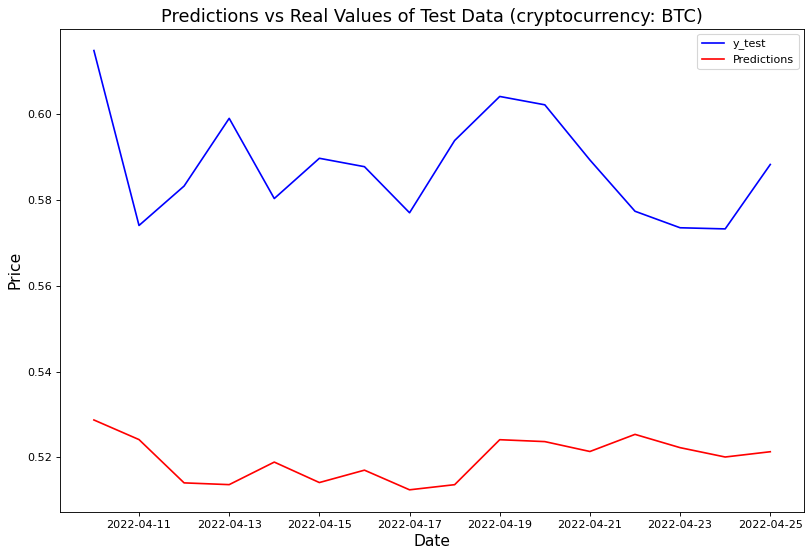

In [77]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results['Date'], results['y_test'], 'b', label = 'y_test')
plt.plot(results['Date'], results['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: BTC)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [78]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.07136510438837036
Train data MSE:  0.005092978124362999
Train data MAE:  0.05902309650318631
-------------------------------------------------------------------------------------
Test data RMSE:  0.06935390857359297
Test data MSE:  0.004809964634434292
Test data MAE:  0.06833721409282173


In [79]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: -1.4871035001623825
Test data R2 score: -32.75485348628343


# Model 2: XGBoost Regressor   <a name="xgboost3"></a>

In [80]:
data5= btc.copy()
data5.reset_index(inplace = True)
data5 = data5[data5['Date'] >= '2022-01-01']
data5.set_index('Date', inplace = True)
print("Total data for prediction: ",data5.shape[0])

Total data for prediction:  115


In [81]:
training_size=int(len(data5)*0.80)
test_size=len(data5)-training_size
train_data,test_data=data5.iloc[:training_size,:],data5.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (92, 7)
test_data:  (23, 7)


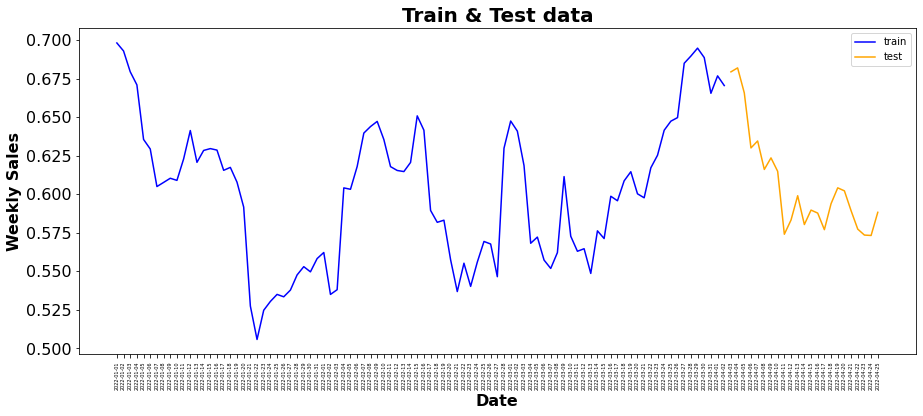

In [82]:
data5.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data5['Date'][:training_size], y = data5['close'][:training_size], color = 'blue')
sns.lineplot(x = data5['Date'][training_size:], y = data5['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [83]:
data5.set_index('Date', inplace = True)

In [84]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [85]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (84, 7, 7)
y_train:  (84,)
X_test:  (15, 7, 7)
y_test (15,)


In [86]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [87]:
model5 = XGBRegressor(n_estimators=1000, random_state = 1)
model5.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, reg_lambda=1, ...)

In [88]:
predictions = model5.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)


predictions_train = model5.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [89]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data5['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
10,0.602196,0.569281,2022-04-21
11,0.589332,0.566231,2022-04-22
12,0.577378,0.575731,2022-04-23
13,0.573527,0.569888,2022-04-24
14,0.573262,0.551204,2022-04-25


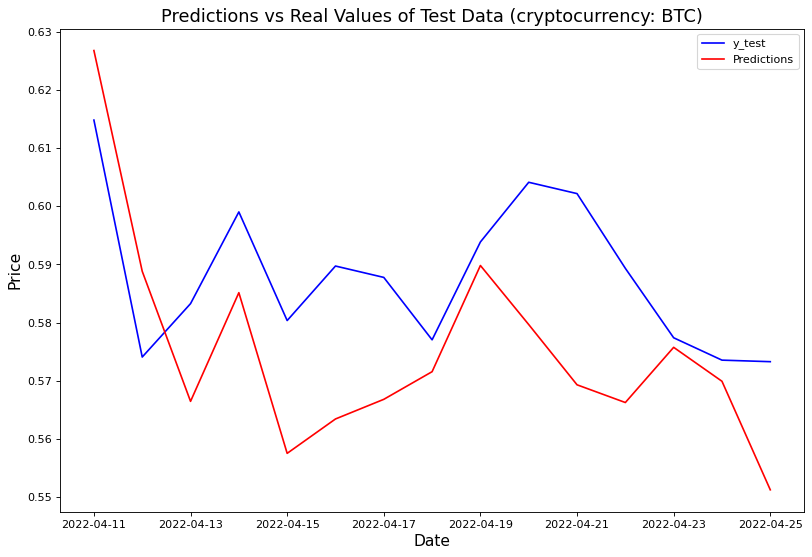

In [90]:
plt.figure(figsize = (12,8), dpi = 80 )
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: BTC)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [91]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  1.7013093309597902e-07
Mean Absolute Error - MAE : 0.000300234435708781
Root Mean squared Error - RMSE : 0.0004124693117020696
R^2 Score 0.9999122155358822
--------------------------------------------------------------
Test data MSE:  0.0003506561800464825
Mean Absolute Error - MAE : 0.016334951204343636
Root Mean squared Error - RMSE : 0.018725815871317397
R^2 Score -1.3070813438271025


# Predictions for the next two days using the best model <a name="predictions"></a>

In [92]:
#Importing the dataset with the updated data
#Use just the 7 past rows, because our model is predicting based on this sliding window
predictions = pd.read_csv('test_BTC.csv', index_col = 'Date')

In [93]:
predictions.tail(7)

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2022-05-02,0.557605,0.092440,0.091904,0.070022,0.050272,0.937916,0.015836
2022-05-03,0.545738,0.076473,0.101506,0.079828,0.058714,0.899925,0.002421
2022-05-04,0.575415,0.103374,0.181525,0.167524,0.138060,0.976723,0.012130
2022-05-05,0.527832,0.121500,0.170560,0.304681,0.246530,0.634292,0.058967
2022-05-06,0.519693,0.106345,0.196731,0.087446,0.069478,0.933616,0.017718
2022-05-07,0.511482,0.068052,0.092799,0.091095,0.074072,0.928549,0.017718
2022-05-08,0.492054,0.103921,0.058244,0.120243,0.103001,0.857696,0.017718


In [94]:
predictions1 = predictions.tail(7)
predictions1 = np.array(predictions1)

In [95]:
x_input=predictions1[len(predictions1)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output9=[]
n_steps=7
i=0
pred_days = 1

In [96]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output9.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output9))

0 day input [0.55760476 0.0924403  0.09190402 0.07002247 0.05027206 0.93791612
 0.01583568 0.54573836 0.07647266 0.1015064  0.07982847 0.05871414
 0.89992489 0.00242126 0.57541549 0.10337444 0.18152501 0.16752441
 0.13806002 0.97672293 0.01213009 0.52783211 0.1214998  0.17055966
 0.30468121 0.2465296  0.63429247 0.05896673 0.51969313 0.10634549
 0.19673073 0.08744592 0.069478   0.93361601 0.01771789 0.51148177
 0.06805169 0.09279858 0.091095   0.07407223 0.92854876 0.01771789
 0.49205437 0.10392101 0.05824436 0.12024295 0.10300062 0.85769576
 0.01771789]
0 day output [0.4802719]
Output of predicted next days:  1


In [97]:
output9  #predicted closing price for May 9th, 2022 (Monday)

[0.4802719056606293]

In [98]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[1 2 3 4 5 6 7]
[8]


In [99]:
# Inserting the prediction for the row May 9th, 2022 --> using new predicted value + data from May 8th 2022 for the other variables 

In [100]:
a = predictions.tail(1).copy()
a.reset_index(inplace = True)
a

,Date,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
0,2022-05-08,0.492054,0.103921,0.058244,0.120243,0.103001,0.857696,0.017718


In [101]:
a.at[0,'Date']='2022-05-09'
a.at[0,'close']= output9[0]
a.set_index('Date', inplace = True)
a

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2022-05-09,0.480272,0.103921,0.058244,0.120243,0.103001,0.857696,0.017718


In [102]:
final_predictions = pd.concat([predictions, a], axis=0, join='outer')

In [103]:
#Get the predicted denormalized closing price using MinMaxScaler formula
intermediate_result = ((67566.828125-1724.23999)*output9[0])+1724.23999

print ("The predicted closing price for BTC on May 9th, 2022 is ", intermediate_result, "USD")

The predicted closing price for BTC on May 9th, 2022 is  33346.585267224385 USD


# Final Predictions<a name="finalpredictions"></a>

In [104]:
final_predictions.tail(7)

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2022-05-03,0.545738,0.076473,0.101506,0.079828,0.058714,0.899925,0.002421
2022-05-04,0.575415,0.103374,0.181525,0.167524,0.138060,0.976723,0.012130
2022-05-05,0.527832,0.121500,0.170560,0.304681,0.246530,0.634292,0.058967
2022-05-06,0.519693,0.106345,0.196731,0.087446,0.069478,0.933616,0.017718
2022-05-07,0.511482,0.068052,0.092799,0.091095,0.074072,0.928549,0.017718
2022-05-08,0.492054,0.103921,0.058244,0.120243,0.103001,0.857696,0.017718
2022-05-09,0.480272,0.103921,0.058244,0.120243,0.103001,0.857696,0.017718


In [105]:
final_predictions1 = final_predictions.tail(7)
final_predictions1 = np.array(final_predictions1)

In [106]:
x_input=(final_predictions1[len(final_predictions1)-(time_step*time_step):]).reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output10=[]
n_steps=7
i=0
pred_days = 1

In [107]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output10.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output10))

0 day input [0.54573836 0.07647266 0.1015064  0.07982847 0.05871414 0.89992489
 0.00242126 0.57541549 0.10337444 0.18152501 0.16752441 0.13806002
 0.97672293 0.01213009 0.52783211 0.1214998  0.17055966 0.30468121
 0.2465296  0.63429247 0.05896673 0.51969313 0.10634549 0.19673073
 0.08744592 0.069478   0.93361601 0.01771789 0.51148177 0.06805169
 0.09279858 0.091095   0.07407223 0.92854876 0.01771789 0.49205437
 0.10392101 0.05824436 0.12024295 0.10300062 0.85769576 0.01771789
 0.48027191 0.10392101 0.05824436 0.12024295 0.10300062 0.85769576
 0.01771789]
0 day output [0.5325445]
Output of predicted next days:  1


In [108]:
print ("The predicted normalized closing price for BTC on May 10th, 2022 is ", output10[0])

The predicted normalized closing price for BTC on May 10th, 2022 is  0.5325444936752319


In [109]:
#Get the predicted denormalized closing price using MinMaxScaler formula
final_result = ((67566.828125-1724.23999)*output10[0])+1724.23999

print ("The predicted closing price for BTC on May 10th, 2022 is ", final_result, "USD")

The predicted closing price for BTC on May 10th, 2022 is  36788.34775062041 USD
